<h2 align="center">mystic</h2>
<h2 align="center">a brief introduction</h2>

<!-- <h2 align="center", style="color:gray">Mike McKerns</h2> -->

The `mystic` framework enables the solving of difficult optimization problems through three major innovations: (1) plug-and-play component-based optimization algorithms, (2) the ability to dynamically construct and apply generalzed trnasforms, `K`, where `x' = K(x)`, and (3) workflows providing asynchronous execution and statefulness.

These features, in conjunction with supporting packages `pathos`, `pyina`, and `klepto`, can provide massively-parallel scalable workflows for quickly solving optimization problems in complex nonlinear spaces. `mystic` can be used to simplify non-convex optimization problems by transforming away nonlinearities through user-built kernel transforms.

This tutorial demonstrates using `mystic` for machine learning with automated dimensional-reduction, using embarrasingly parallel solver ensembles to find an accurate interpolated surrogate for a nonlinear surface, and the determination of worst-case bounds on expectation value of an objective function under uncertainty.

#### Plug-and-play optimization

 - `mystic` has a basic interface similar to `scipy.optimize`

In [1]:
# Powell's Directonal solver
from mystic.solvers import fmin_powell

# Rosenbrock function
from mystic.models import rosen

# initial guess
x0 = [0.8,1.2,0.7]

# use Powell's method to minimize the Rosenbrock function
solution = fmin_powell(rosen,x0)
print(solution)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 524
[1. 1. 1.]


 - `mystic` solvers can accept customizable components, such as a callback

In [3]:
# Powell's Directonal solver
from mystic.solvers import fmin_powell

# Rosenbrock function
from mystic.models import rosen

iter = 0
# plot the parameter trajectories
def print_params(params):
    global iter
    from numpy import asarray
    print("Generation %d has best fit parameters: %s" % (iter,asarray(params)))
    iter += 1
    return

# initial guess
x0 = [0.8,1.2,0.7]
print_params(x0)

# use Powell's method to minimize the Rosenbrock function
solution = fmin_powell(rosen,x0,disp=1,callback=print_params)
print(solution)

Generation 0 has best fit parameters: [0.8 1.2 0.7]
Generation 1 has best fit parameters: [0.8 1.2 0.7]
Generation 2 has best fit parameters: [1.096641   0.92316246 0.85222892]
Generation 3 has best fit parameters: [0.96098383 0.92341029 0.85268657]
Generation 4 has best fit parameters: [0.96116068 0.92362873 0.85268597]
Generation 5 has best fit parameters: [0.96139941 0.92394456 0.85319715]
Generation 6 has best fit parameters: [0.96490397 0.9293998  0.86287626]
Generation 7 has best fit parameters: [0.97283782 0.9438172  0.8900223 ]
Generation 8 has best fit parameters: [0.99282304 0.98392465 0.9676975 ]
Generation 9 has best fit parameters: [0.99599362 0.99123752 0.98220233]
Generation 10 has best fit parameters: [0.99933371 0.99875944 0.9973022 ]
Generation 11 has best fit parameters: [0.99959358 0.99924252 0.99835369]
Generation 12 has best fit parameters: [1.00000002 1.00000006 1.00000011]
Generation 13 has best fit parameters: [1. 1. 1.]
Generation 14 has best fit parameters: [

 - solvers can be further customized with `monitors` that record solver history, and `constraints` that transform the space the optimizer searches

In [12]:
# Powell's Directonal solver
from mystic.solvers import fmin_powell

# Rosenbrock function
from mystic.models import rosen

# monitor
from mystic.monitors import VerboseMonitor

# initial guess
x0 = [0.8,1.2,0.7]

# use the mean constraints factory decorator
from mystic.constraints import with_mean

# define constraints function
@with_mean(1.0)
def constraints(x):
    x[-1] = x[0]
    return x

# configure monitor
stepmon = VerboseMonitor(0,1)

# use Powell's method to minimize the Rosenbrock function
solution = fmin_powell(rosen,x0,constraints=constraints,itermon=stepmon)
print(solution)

Generation 0 has fit parameters:
 [0.8666666666666667, 1.2666666666666666, 0.8666666666666667]
Generation 1 has fit parameters:
 [0.999999999999819, 1.0000000000003622, 0.999999999999819]
Generation 2 has fit parameters:
 [1.0000000000000002, 0.9999999999999999, 1.0000000000000002]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 81
STOP("NormalizedChangeOverGeneration with {'tolerance': 0.0001, 'generations': 2}")
[1. 1. 1.]


 - `mystic` provides an expanded interface, enabling advanced users to perform more granular customization, facilitating the construciton of new optimization-related tools.

In [50]:
# Differential Evolution solver
from mystic.solvers import DifferentialEvolutionSolver2

# Chebyshev cost function
from mystic.models.poly import chebyshev8cost

# Termination and Monitor
from mystic.termination import Or, VTR, ChangeOverGeneration
from mystic.monitors import VerboseMonitor

# Misc tools
from mystic.constraints import near_integers, integers
from mystic.penalty import quadratic_inequality
from mystic.tools import random_seed, suppressed
from mystic.math import poly1d

# set problem size and random seed
ndim = 9
random_seed(123)

@quadratic_inequality(near_integers)
def rounded(x):
    return 0.0

@integers()
def round(x):
    return x

@suppressed(1)
def cost(x):
    return chebyshev8cost(x)

# use DE to solve 8th-order Chebyshev coefficients
solver = DifferentialEvolutionSolver2(ndim, 100)
solver.SetRandomInitialPoints(min=[-300]*ndim, max=[300]*ndim)
solver.SetStrictRanges(min=[-300]*ndim, max=[300]*ndim)
solver.SetGenerationMonitor(VerboseMonitor(100))
solver.SetPenalty(rounded)
solver.SetConstraints(round)
solver.SetTermination(Or(VTR(1e-8),ChangeOverGeneration(1e-8, 200)))
solver.SetObjective(cost)
solver.Solve()

# retrieve results information
print("Generation %d has best Chi-Squared: %f" % (solver.generations, solver.bestEnergy))
print(poly1d(solver.bestSolution))

Generation 0 has ChiSquare: 665355.791857
Generation 100 has ChiSquare: 5786.100337
Generation 200 has ChiSquare: 59.237363
Generation 300 has ChiSquare: 10.649534
Generation 400 has ChiSquare: 3.942873
Generation 500 has ChiSquare: 2.000000
STOP("VTR with {'tolerance': 1e-08, 'target': 0.0}")
Generation 588 has best Chi-Squared: 0.000000
     8       6       4      2
128 x - 256 x + 160 x - 32 x + 1


#### Penalties and constraints

  - `mystic` provides an unique abilty to build and apply compound user-defined penalties `y = P(x)` and  transforms `x' = K(x)`.  After a transform `K` is applied, optimizations are then performed in the space of valid solutions, with respect to the set of functional, statistical, or data constraints defined by `K`. Similarly, penalties `P` discourage the solver from finding solutions that violate the constraints defined by `P`.

In [76]:
from mystic.solvers import diffev2
from mystic.monitors import VerboseMonitor
from mystic.constraints import impose_sum, discrete, and_
import numpy as np

# set number of variables, bounds constraints, and sum constraint
N,b = 10,5
bounds = [(0,1)] * N

# build objective
def objective(x, w):
    s = 0
    for i in range(len(x)-1):
        for j in range(i, len(x)):
            s += w[i,j] * x[i] * x[j]
    return s

# set dummy weights
w = np.ones((N,N))

# invert objective, as we are maximizing
cost = lambda x: -objective(x, w)

# constrain to have "b" True values, and to be binary variables
c = and_(lambda x: impose_sum(b, x), discrete([0,1])(lambda x:x))

mon = VerboseMonitor(10)
solution = diffev2(cost,bounds,constraints=c,bounds=bounds,itermon=mon,\
                               gtol=50,maxiter=5000,maxfun=50000,npop=10)
print(solution)

Generation 0 has ChiSquare: -15.000000
Generation 10 has ChiSquare: -15.000000
Generation 20 has ChiSquare: -15.000000
Generation 30 has ChiSquare: -15.000000
Generation 40 has ChiSquare: -15.000000
Generation 50 has ChiSquare: -15.000000
STOP("ChangeOverGeneration with {'tolerance': 0.005, 'generations': 50}")
Optimization terminated successfully.
         Current function value: -15.000000
         Iterations: 50
         Function evaluations: 510
[1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]


 - In addition to accepting constraints funcitons, `mystic` can also digest symbolic constraints.

In [75]:
# define objective
def cost(x):
    return 0.0

# set bounds
bounds = [(0,10)]*7

# define constraints
equations = """
98527*x0 + 34588*x1 + 5872*x2 + 59422*x4 + 65159*x6 - 1547604 - 30704*x3 - 29649*x5 == 0.0
98957*x1 + 83634*x2 + 69966*x3 + 62038*x4 + 37164*x5 + 85413*x6 - 1823553 - 93989*x0 == 0.0
900032 + 10949*x0 + 77761*x1 + 67052*x4 - 80197*x2 - 61944*x3 - 92964*x5 - 44550*x6 == 0.0
73947*x0 + 84391*x2 + 81310*x4 - 1164380 - 96253*x1 - 44247*x3 - 70582*x5 - 33054*x6 == 0.0
13057*x2 + 42253*x3 + 77527*x4 + 96552*x6 - 1185471 - 60152*x0 - 21103*x1 - 97932*x5 == 0.0
1394152 + 66920*x0 + 55679*x3 - 64234*x1 - 65337*x2 - 45581*x4 - 67707*x5 - 98038*x6 == 0.0
68550*x0 + 27886*x1 + 31716*x2 + 73597*x3 + 38835*x6 - 279091 - 88963*x4 - 76391*x5 == 0.0
76132*x1 + 71860*x2 + 22770*x3 + 68211*x4 + 78587*x5 - 480923 - 48224*x0 - 82817*x6 == 0.0
519878 + 94198*x1 + 87234*x2 + 37498*x3 - 71583*x0 - 25728*x4 - 25495*x5 - 70023*x6 == 0.0
361921 + 78693*x0 + 38592*x4 + 38478*x5 - 94129*x1 - 43188*x2 - 82528*x3 - 69025*x6 == 0.0
"""

from mystic.symbolic import generate_constraint, generate_solvers, solve
cf = generate_constraint(generate_solvers(solve(equations)))

from numpy import round as npround
from mystic.solvers import diffev2

result = diffev2(cost, x0=bounds, bounds=bounds, constraints=cf, npop=4, gtol=1, disp=True)
print(result)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 14
[6. 0. 8. 4. 9. 3. 9.]


#### Asynchronous execution, solver restarts, and saving state

 - all of the solvers in `mystic` can run until converged (with `Solve`) or progress asynchronously on a per-iteration basis (with `Step`). `mystic` provides utilities that check for termination and/or dimensional collapse, as well as stateful solvers that can be dynamically saved and stored, reloaded, modified, and restarted.

In [83]:
from mystic.solvers import DifferentialEvolutionSolver
from mystic.solvers import NelderMeadSimplexSolver
from mystic.termination import VTR, ChangeOverGeneration, When, Or
from mystic.monitors import VerboseMonitor
from mystic.models import rosen
from mystic.solvers import LoadSolver
import os

# instantiate and configure the solver
_solver = NelderMeadSimplexSolver(3)
lb,ub = [0.,0.,0.],[10.,10.,10.]
_solver.SetRandomInitialPoints(lb, ub)
_solver.SetEvaluationLimits(1000)
_solver.SetGenerationMonitor(VerboseMonitor(10))
_solver.SetStrictRanges(lb, ub)
_solver.SetTermination(Or( VTR(), ChangeOverGeneration() ))
_solver.SetObjective(rosen)
    
# add a periodic dump to an archive
tmpfile = 'mysolver.pkl'
_solver.SetSaveFrequency(50, tmpfile)

# run the optimizer
while not _solver.Terminated():
    _solver.Step(disp=1)

# load the most recent saved solver
solver = LoadSolver(tmpfile)

# modify the termination condition
solver.SetTermination(VTR(0.000001))

# restart the optimizer, and clean up
solver.Solve(disp=1)
os.remove(tmpfile)

Generation 0 has ChiSquare: 37736.740224
DUMPED("mysolver.pkl")
Generation 10 has ChiSquare: 2028.123247
Generation 20 has ChiSquare: 12.792163
Generation 30 has ChiSquare: 5.335982
Generation 40 has ChiSquare: 5.190954
Generation 50 has ChiSquare: 5.145140
DUMPED("mysolver.pkl")
Generation 60 has ChiSquare: 4.702065
Generation 70 has ChiSquare: 3.178831
Generation 80 has ChiSquare: 2.305518
Generation 90 has ChiSquare: 1.321103
Generation 100 has ChiSquare: 0.483058
DUMPED("mysolver.pkl")
Generation 110 has ChiSquare: 0.255416
Generation 120 has ChiSquare: 0.098026
Generation 130 has ChiSquare: 0.039686
Generation 140 has ChiSquare: 0.025292
Generation 150 has ChiSquare: 0.012213
DUMPED("mysolver.pkl")
Optimization terminated successfully.
         Current function value: 0.004727
         Iterations: 156
         Function evaluations: 262
STOP("VTR with {'tolerance': 0.005, 'target': 0.0}")
DUMPED("mysolver.pkl")
LOADED("mysolver.pkl")
Generation 160 has ChiSquare: 0.004727
Generatio

#### Auto-dimensional reduction

 - Solvers accept two forms of stop conditions: (1) termination, and (2) collapse.  Collapse conditions are those that define how to dynamically reduce elements of the optimization, such as how to reduce the number of input parameters or the region of search space. Here we demonstrate a support-vector regression using a numerical kernel transform with a dimensional collapse targeted to zero-out points with small support.

Generation 0 has ChiSquare: 1.702585
STOP("CollapseAt with {'mask': None, 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([11, 4])")
STOP("CollapseAt with {'mask': set([11, 4]), 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([7])")
STOP("CollapseAt with {'mask': set([11, 4, 7]), 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([12])")
STOP("CollapseAt with {'mask': set([12, 11, 4, 7]), 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([9])")
STOP("CollapseAt with {'mask': set([4, 11, 12, 9, 7]), 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([15])")
STOP("CollapseAt with {'mask': set([4, 7, 9, 11, 12, 15]), 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([21])")
STOP("CollapseAt with {'mask': set([4, 7, 9, 11, 12, 15, 21]), 'tolerance': 0.0001, 'target': 0.0, 'generations': 50} at set([3])")
STOP("CollapseAt with {'mask': set([3, 4, 7, 9, 11, 12, 15, 21]), 'tolerance': 0.0001, 'target': 0.0, 'generations

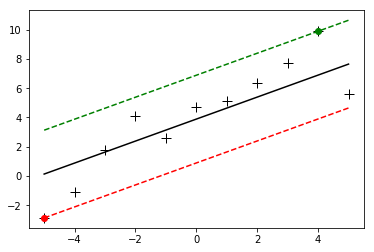

In [88]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt
from mystic.svr import *

# define the objective function to match standard QP solver
def objective(x, Q, b):
    return 0.5 * dot(dot(x,Q),x) + dot(b,x)

# generate some linear data with uniform scatter
x = arange(-5, 5.001); nx = x.size
y = x + 7*random.rand(nx)
N = 2*nx

# build the Kernel Matrix
# get the QP quadratic term
X = concatenate([x,-x])
lk = LinearKernel
Q = KernelMatrix(X, kernel=lk)
# get the QP linear term
Y = concatenate([y,-y])
svr_epsilon = 3
b = Y + svr_epsilon * ones(Y.shape)

# build the constraints (y.T * x = 0.0)
# 1.0*x0 + 1.0*x1 + ... - 1.0*xN = 0.0
Aeq = concatenate([ones(nx), -ones(nx)]).reshape(1,N)
Beq = array([0.])
# set the bounds
lb = zeros(N)
ub = zeros(N) + 2.0
_b = zeros(N)
b_ = zeros(N) + 0.1

# build the constraints operator
from mystic.symbolic import linear_symbolic, solve, generate_solvers, generate_constraint
constrain = linear_symbolic(Aeq,Beq)
constrain = generate_constraint(generate_solvers(solve(constrain,target=['x0'])))

from mystic import suppressed
@suppressed(1e-5)
def conserve(x):
    return constrain(x)

# solve for alpha
from mystic.solvers import DifferentialEvolutionSolver as DESolver
from mystic.termination import Or, ChangeOverGeneration, CollapseAt
from mystic.monitors import VerboseMonitor
solver = DESolver(len(lb), 3*N)
solver.SetRandomInitialPoints(min=_b,max=b_)
solver.SetStrictRanges(min=lb,max=ub)
solver.SetGenerationMonitor(VerboseMonitor(1000))
solver.SetConstraints(conserve)
solver.SetTermination(Or(ChangeOverGeneration(1e-8,200),CollapseAt(0.0)))
solver.Solve(objective, ExtraArgs=(Q,b), disp=0)
alpha = solver.bestSolution

print('solved x: %s' % alpha)
print("constraint A*x == 0: %s" % inner(Aeq, alpha))
print("minimum 0.5*x'Qx + b'*x: %s" % solver.bestEnergy)

# calculate support vectors and regression function
sv1 = SupportVectors(alpha[:nx])
sv2 = SupportVectors(alpha[nx:])
R = RegressionFunction(x, y, alpha, svr_epsilon, lk)

print('support vectors: %s %s' % (sv1, sv2))

# plot data
plt.plot(x, y, 'k+', markersize=10)

# plot regression function and support
plt.plot(x,R(x), 'k-')
plt.plot(x,R(x)-svr_epsilon, 'r--')
plt.plot(x,R(x)+svr_epsilon, 'g--')
plt.plot(x[sv1],y[sv1],'ro')
plt.plot(x[sv2],y[sv2],'go')
plt.show()

#### Hyperparameter optimization

Here we do an optimization with a parallel ensemble of solvers utilizing a space-filling algorithm to efficiently search hyperparameter space. This is an improvement over sampling on a grid, as an ensemble of optimizers quickly search for local minima in their own portion of the search space. Essentially, a multiplicity of local optimizers approximates a fast global optimization.

In [102]:
from sklearn.datasets import load_iris
iris = load_iris()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
x_train,x_test,y_train,y_test = train_test_split(iris.data[:,:-1],iris.data[:,-1],test_size=.2)

def cost(x):
    return SVR(kernel='linear', C=x[0]).fit(x_train, y_train).score(x_test, y_test)

try:
    from pathos.pools import ProcessPool as Pool
except ImportError:
    from mystic.pools import SerialPool as Pool

from mystic.solvers import sparsity
sparsity(cost, 1, npts=200, bounds=[(1,10)], gtol=20, map=Pool().map)

Optimization terminated successfully.
         Current function value: 0.907491
         Iterations: 20
         Function evaluations: 49
         Total function evaluations: 10206


array([2.50189519])

#### Parallel solver and ensemble solvers

 - `mystic` provides a simple interface to launch an ensemble of optimizers in parallel

In [23]:
# the Sparsity solver and Powell's solver
from mystic.solvers import SparsitySolver
from mystic.solvers import PowellDirectionalSolver

try:
    from pathos.pools import ProcessPool as Pool
except ImportError:
    from mystic.pools import SerialPool as Pool

# Chebyshev cost function
from mystic.models.poly import chebyshev8cost

# Termination and Monitor
from mystic.termination import Or, VTR, ChangeOverGeneration
from mystic.monitors import Monitor

# Misc tools
from mystic.tools import random_seed
from mystic.math import poly1d

# dimensionality of the problem and size of the ensemble
ndim, npts = 9, 256
random_seed(123)

# use DE to solve 8th-order Chebyshev coefficients
solver = SparsitySolver(ndim, npts)
solver.SetNestedSolver(PowellDirectionalSolver)
solver.SetMapper(Pool().map)
solver.SetStrictRanges(min=[-300]*ndim, max=[300]*ndim)
solver.SetGenerationMonitor(Monitor())
solver.SetTermination(Or(VTR(1e-8),ChangeOverGeneration(1e-8, 5)))
solver.SetObjective(chebyshev8cost)
solver.Solve()

# retrieve results information
print("Generation %d has best Chi-Squared: %f" % (solver.generations, solver.bestEnergy))
print(poly1d(solver.bestSolution))

Generation 45 has best Chi-Squared: 4.103139
       8         7       6         5       4        3         2
110.5 x + 1.479 x - 205 x - 3.853 x + 114 x + 2.96 x - 19.66 x - 0.6505 x + 1.477


#### Supporting packages

 - `mystic` can use a variety of `map` functions from `pathos` (shown above) and `pyina`. `pathos` provides a worker `Pool` using multiprocessing, multithreading, and/or distributed computing. `pyina` provides a worker `Pool` using MPI and/or cluster schedulers, like torque and slurm. 

In [115]:
from numpy import arange

# default # of rectangles
n = 20000

integration_points = (arange(1,n+1)-0.5)/n

def f(x):
    return 4.0/(1.0+x*x)

# configure and run the worker pool
from pyina.launchers import MpiPool
from pyina.launchers import TorqueMpiPool

pool = MpiPool(2)
# pool = TorqueMpiPool('5:ppn=2', queue='productionQ', timelimit='20:00:00', workdir='.')
out = pool.map(f, integration_points)

from pyina import mpi
if mpi.world.rank == 0:
    print("approxmiate pi : ", sum(out)/n)

('approxmiate pi : ', 3.1415926537981265)


 - `klepto` provides local in-memory caching of functions, as well as a dictionary interface to shared archives for longer-term storage.  Entries in `klepto` archives can be text files, SQL tables, or HDF files.

In [11]:
from klepto.keymaps import hashmap
from klepto import lru_cache as memoize
from klepto.archives import dict_archive

hasher = hashmap(algorithm='md5')
store = dict_archive('archive')

class Adder(object):
    @memoize(keymap=hasher, ignore=('self','**'), cache=store)
    def __call__(self, x, *args, **kwds):
        return sum((x,)+args)

    add = __call__

# get an instance of Adder with a cached __call__ function
add = Adder()
x = list(map(add, range(10), [1]*10))
print(add.__call__.info())

# repeat calls, pulling results from cache instead of recalculating
x = list(map(add, range(10), [1]*10))
print(add.__call__.info())

# get a new Adder instance, with a shared cache
plus = Adder()
cache = plus.__call__.__cache__()
print('cache is shared: {}'.format(x == sorted(cache.values())))

# lookup an existing key
print('key (2,1) in cache: {}'.format(add.__call__.lookup(add, 2,1) == 3))

# try to lookup a missing key
try:
    add.__call__.lookup(add, 2,0)
except KeyError:
    print('key (2,0) not in cache')

# get key from cache
print('key for (2,0): {}'.format(add.__call__.key(add, 2,0)))
key = add.__call__.key(add, 2,1)
print('cache has key for (2,1): {}'.format(cache[key] == 3))

# get the shared cache archive
archive = cache.__archive__

# save all cache keys to the archive, then remove all cached keys
cache.dump()
cache.clear()
print('cache is cleared')
print('cache has key for (2,1): {}'.format(cache.has_key(key)))

# load all cache keys from the archive
cache.load()
print('cache is loaded')
print('cache has key for (2,1): {}'.format(cache.has_key(key)))
print('all values are restored: {}'.format(sorted(cache.values()) == x))

# get a new cache with the same shared archive
cache2 = dict_archive('foo', cached=True)
cache2.archive = archive
print('cache2 is empty: {}'.format(bool(cache2.values())))

# load values from archive
cache2.load()
print('cache2 has loaded: {}'.format(x == sorted(cache2.values())))

# add a value to the new archive
key2 = add.__call__.key(add,10,1)
cache2[key2] = 12
print('added key (10,1) to cache2')

# pass the new value to the original cache
cache2.dump(key2)
cache.load(key2)
print('cache has key for (10,1): {}'.format(cache.get(key2) == 12))

CacheInfo(hit=0, miss=10, load=0, maxsize=100, size=10)
CacheInfo(hit=10, miss=10, load=0, maxsize=100, size=10)
cache is shared: True
key (2,1) in cache: True
key (2,0) not in cache
key for (2,0): cfd9809c56982c2baf98916f82b19a4e
cache has key for (2,1): True
cache is cleared
cache has key for (2,1): False
cache is loaded
cache has key for (2,1): True
all values are restored: True
cache2 is empty: False
cache2 has loaded: True
added key (10,1) to cache2
cache has key for (10,1): True


#### Surface interpolation

Here an ensemble of solvers is used to quickly discover all local minima and maxima on a surface defined by a model, with the goal of finding a function that accurately approximates the model. `mystic` provides interpolation algorithms that integrate well with it's suite of optimization algorithms.

min: 0.0 (count=1)
pts: 17 (values=7, size=17)
max: 2.04197668684 (count=4)
pts: 18 (values=6, size=18)
for speed, sampling 3133 down to 1044
min: 0.0; min@f: -3.08500602841e-09
max: 2.04197668684; max@f: 2.04197667167


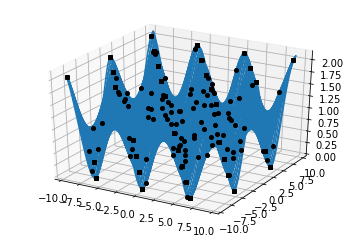

sum diff squares
actual and interp: 8.457353641627026e-13


In [122]:
%matplotlib inline
from mystic.search import Searcher


if __name__ == '__main__':
    # if available, use a multiprocessing worker pool
    from mystic.pools import SerialPool as Pool

    # tools
    from mystic.termination import VTR, ChangeOverGeneration as COG
    from mystic.termination import NormalizedChangeOverGeneration as NCOG
    from mystic.monitors import LoggingMonitor, VerboseMonitor, Monitor
    from klepto.archives import dir_archive

    stop = NCOG(1e-4)
    disp = False # print optimization summary
    stepmon = False # use LoggingMonitor
    archive = False # save an archive

    traj = not stepmon # save all trajectories internally, if no logs

    # cost function
    from mystic.models import griewangk as model
    ndim = 2  # model dimensionality
    bounds = ndim * [(-9.5,9.5)] # griewangk

    # the ensemble solvers
    from mystic.solvers import BuckshotSolver, LatticeSolver
    # the local solvers
    from mystic.solvers import PowellDirectionalSolver

    sprayer = BuckshotSolver
    seeker = PowellDirectionalSolver
    npts = 25 # number of solvers
    _map = Pool().map
    retry = 1 # max consectutive iteration retries without a cache 'miss'
    tol = 8   # rounding precision
    mem = 1   # cache rounding precision

    # 'configure' monitor and archive if they are desired
    if stepmon: stepmon = LoggingMonitor(1) # montor for all runs
    else: stepmon = None
    if archive: #python2.5
        name = getattr(model,'__name__','model')
        ar_name = '__%s_%sD_cache__' % (name,ndim)
        archive = dir_archive(ar_name, serialized=True, cached=False)
    else: archive = None

    searcher = Searcher(npts, retry, tol, mem, _map, archive, sprayer, seeker)
    searcher.Verbose(disp)
    searcher.UseTrajectories(traj)

    searcher.Reset(archive, inv=False)
    searcher.Search(model, bounds, stop=stop, monitor=stepmon)
    searcher._summarize()

    ##### extract results #####
    xyz = searcher.Samples()

    ##### invert the model, and get the maxima #####
    imodel = lambda *args, **kwds: -model(*args, **kwds)

    # 'configure' monitor and archive if they are desired
    if stepmon not in (None, False):
        itermon = LoggingMonitor(1, filename='inv.txt') #XXX: log.txt?
    else: itermon = None
    if archive not in (None, False): #python2.5
        name = getattr(model,'__name__','model')
        ar_name = '__%s_%sD_invcache__' % (name,ndim)
        archive = dir_archive(ar_name, serialized=True, cached=False)
    else: archive = None

    searcher.Reset(archive, inv=True)
    searcher.Search(imodel, bounds, stop=stop, monitor=itermon)
    searcher._summarize()

    ##### extract results #####
    import numpy as np
    xyz = np.hstack((xyz, searcher.Samples()))

    ########## interpolate ##########
    from mystic.math.interpolate import Rbf

    #############
    shift = 0
    scale = 0
    N = 1000.
    M = 200
    args = {
    'smooth': 0,
    'function': 'thin_plate',
    }
    #############

    # get params (x) and cost (z)
    x, z = xyz.T[:,:-1], xyz.T[:,-1]

    # hack to remove any duplicate points by adding noise
    _x = x + np.random.normal(scale=1e-8, size=x.shape)

    if len(z) > N:
        N = max(int(round(len(z)/float(N))),1)
        print("for speed, sampling {} down to {}".format(len(z),len(z)/N))
        x, _x, z = x[::N], _x[::N], z[::N]

    f = Rbf(*np.vstack((_x.T, z)), **args)
    f.__doc__ = model.__doc__
    # convert to 'model' format (i.e. takes a parameter vector)
    _model = lambda x: f(*x).tolist()
    _model.__doc__ = f.__doc__

    mz = np.argmin(z)
    print("min: {}; min@f: {}".format(z[mz], f(*x[mz])))
    mz = np.argmax(z)
    print("max: {}; max@f: {}".format(z[mz], f(*x[mz])))

    # plot
    #############
    # specify 2-of-N dim (with bounds) and (N-2) with values
    axes = (0,1)  # axes to plot               (specified by user)
    vals = ()     # values for remaining param (specified by user)
    #############

    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    from matplotlib import cm

    figure = plt.figure()
    kwds = {'projection':'3d'}
    ax = figure.gca(**kwds)
    ax.autoscale(tight=True)

    # build a list of fixed values and override with user input
    ix = [i for i in range(len(x.T)) if i not in axes]
    fix = enumerate(x[np.argmin(z)])
    fix = np.array(tuple(j for (i,j) in fix if i not in axes))
    fix[:len(vals)] = vals

    # build a grid of points, one for each param, and apply fixed values
    grid = np.ones((len(x.T),M,M))
    grid[ix] = fix[:,None,None]
    del ix, fix

    # build the sub-surface of surrogate(x) to display, and apply to the grid
    axes = list(axes)
    xy = x.T[axes]
    S = complex('{}j'.format(M))
    grid[axes] = np.mgrid[xy[0].min():xy[0].max():S, xy[1].min():xy[1].max():S]
    del xy

    # evaluate the surrogate on the sub-surface
    z_ = f(*grid)

    # scaling used by model plotter
    if scale:
        if shift:
            z_ = np.asarray(z_)+shift
            z = np.asarray(z)+shift
        z_ = np.log(4*np.asarray(z_)*scale+1)+2
        z = np.log(4*np.asarray(z)*scale+1)+2

    # plot the surface and points
    density = 9
    d = max(11 - density, 1)
    x_ = grid[axes[0]]
    y_ = grid[axes[-1]]
    ax.plot_wireframe(x_, y_, z_, rstride=d, cstride=d)
    #ax.plot_surface(x_, y_, z_, rstride=d, cstride=d, cmap=cm.jet, linewidth=0, antialiased=False)
    x_ = x.T[axes[0]]
    y_ = x.T[axes[-1]]
    ax.plot(x_, y_, z, 'ko', linewidth=2, markersize=4)

    plt.show()

    # some testing of interpolated model
    data = np.asarray(z)
    interp = f(*x.T)
    print("sum diff squares")
    print("actual and interp: %s" % np.sum((data - interp)**2))

#### Uncertainty quantification

Here `mystic` is used to find rigorous bounds on the probability of failure for a model of hypervelocity impact. The cost function takes a user-defined model, and uses it to calculate the probability of failure.  The optimization is performed in a transformed parameter space, with the transformation defined by constraints on a product measure composed of all valid weights and positions for the model. This enables a user to define moment constraints on input and output parameters without specifying the input distributions (as would be done with, for example, Bayesian inference). `mystic` solves for the scenarios (i.e. combinations of weights and positions) that represent the extremizers for all possible inputs.

In [13]:
#######################################################################
# solver configuration
#######################################################################
MINMAX = -1  ## NOTE: sup = maximize = -1; inf = minimize = 1
npop = 40
maxiter = 1000
maxfun = 1e+6
convergence_tol = 1e-6; ngen = 40
crossover = 0.9
percent_change = 0.9


#######################################################################
# the model function
#######################################################################
from math import pi, cos, tanh

def ballistic_limit(h,a):
  Ho = 0.5794
  s = 1.4004
  n = 0.4482
  return Ho * ( h / cos(a)**n )**s

def model(x):
  h = x[0] * 25.4 * 1e-3
  a = x[1] * pi/180.0
  v = x[2]

  K = 10.3963
  p = 0.4757
  u = 1.0275
  m = 0.4682
  Dp = 1.778

  # compare to ballistic limit
  v_bl = ballistic_limit(h,a)
  if v < v_bl:
    return 0

  return K * (h/Dp)**p * (cos(a))**u * (tanh((v/v_bl)-1))**m


#######################################################################
# the differential evolution optimizer
#######################################################################
def optimize(cost,_bounds,_constraints):
  from mystic.solvers import DifferentialEvolutionSolver2
  from mystic.termination import ChangeOverGeneration as COG
  from mystic.strategy import Best1Exp
  from mystic.monitors import VerboseMonitor, Monitor
  from mystic.tools import random_seed

  stepmon = VerboseMonitor(50)
  evalmon = Monitor()

  lb,ub = _bounds
  ndim = len(lb)

  solver = DifferentialEvolutionSolver2(ndim,npop)
  solver.SetRandomInitialPoints(min=lb,max=ub)
  solver.SetStrictRanges(min=lb,max=ub)
  solver.SetEvaluationLimits(maxiter,maxfun)
  solver.SetEvaluationMonitor(evalmon)
  solver.SetGenerationMonitor(stepmon)
  solver.SetConstraints(_constraints)

  tol = convergence_tol
  solver.Solve(cost,termination=COG(tol,ngen),strategy=Best1Exp, \
               CrossProbability=crossover,ScalingFactor=percent_change)

  solved = solver.bestSolution
  func_max = MINMAX * solver.bestEnergy       #NOTE: -solution assumes -Max
  func_evals = solver.evaluations
  return solved, func_max, func_evals


#######################################################################
# maximize the function
#######################################################################
def maximize(params,npts,bounds):

  from mystic.math.measures import split_param
  from mystic.math.discrete import product_measure
  from mystic.math import almostEqual
  from numpy import inf
  atol = 1e-18 # default is 1e-18
  rtol = 1e-7  # default is 1e-7
  target,error = params
  lb,ub = bounds

  # split lower & upper bounds into weight-only & sample-only
  w_lb, x_lb = split_param(lb, npts)
  w_ub, x_ub = split_param(ub, npts)

  # generate primary constraints function
  def constraints(rv):
    c = product_measure().load(rv, npts)
    # NOTE: bounds wi in [0,1] enforced by filtering
    # impose norm on each discrete measure
    for measure in c:
      if not almostEqual(float(measure.mass), 1.0, tol=atol, rel=rtol):
        measure.normalize()
    # impose expectation on product measure
    E = float(c.expect(model))
    if not (E <= float(target[0] + error[0])) \
    or not (float(target[0] - error[0]) <= E):
      c.set_expect(target[0], model, (x_lb,x_ub), tol=error[0])
    # extract weights and positions
    return c.flatten()

  # generate maximizing function
  def cost(rv):
    c = product_measure().load(rv, npts)
    E = float(c.expect(model))
    if E > (target[0] + error[0]) or E < (target[0] - error[0]):
      return inf  #XXX: FORCE TO SATISFY E CONSTRAINTS
    return MINMAX * c.pof(model)

  # maximize
  solved, func_max, func_evals = optimize(cost,(lb,ub),constraints)

  if MINMAX == 1:
    print("func_minimum: %s" % func_max)  # inf
  else:
    print("func_maximum: %s" % func_max)  # sup
  print("func_evals: %s" % func_evals)

  return solved, func_max


#######################################################################
# rank, bounds, and restart information 
#######################################################################
if __name__ == '__main__':
  function_name = model.__name__

  H_mean = 6.5    #NOTE: SET THE 'mean' HERE!
  H_range = 1.0   #NOTE: SET THE 'range' HERE!
  nx = 2  #NOTE: SET THE NUMBER OF 'h' POINTS HERE!
  ny = 2  #NOTE: SET THE NUMBER OF 'a' POINTS HERE!
  nz = 2  #NOTE: SET THE NUMBER OF 'v' POINTS HERE!
  target = (H_mean,)
  error = (H_range,)

  w_lower = [0.0]
  w_upper = [1.0]
  h_lower = [60.0];  a_lower = [0.0];  v_lower = [2.1]
  h_upper = [105.0]; a_upper = [30.0]; v_upper = [2.8]

  lower_bounds = (nx * w_lower) + (nx * h_lower) \
               + (ny * w_lower) + (ny * a_lower) \
               + (nz * w_lower) + (nz * v_lower) 
  upper_bounds = (nx * w_upper) + (nx * h_upper) \
               + (ny * w_upper) + (ny * a_upper) \
               + (nz * w_upper) + (nz * v_upper) 

  print("...SETTINGS...")
  print("npop = %s" % npop)
  print("maxiter = %s" % maxiter)
  print("maxfun = %s" % maxfun)
  print("convergence_tol = %s" % convergence_tol)
  print("crossover = %s" % crossover)
  print("percent_change = %s" % percent_change)
  print("..............\n")

  print(" model: f(x) = %s(x)" % function_name)
  print(" target: %s" % str(target))
  print(" error: %s" % str(error))
  print(" npts: %s" % str((nx,ny,nz)))
  print("..............\n")

  param_string = "["
  for i in range(nx):
    param_string += "'wx%s', " % str(i+1)
  for i in range(nx):
    param_string += "'x%s', " % str(i+1)
  for i in range(ny):
    param_string += "'wy%s', " % str(i+1)
  for i in range(ny):
    param_string += "'y%s', " % str(i+1)
  for i in range(nz):
    param_string += "'wz%s', " % str(i+1)
  for i in range(nz):
    param_string += "'z%s', " % str(i+1)
  param_string = param_string[:-2] + "]"

  print(" parameters: %s" % param_string)
  print(" lower bounds: %s" % lower_bounds)
  print(" upper bounds: %s" % upper_bounds)
  pars = (target,error)
  npts = (nx,ny,nz)
  bounds = (lower_bounds,upper_bounds)
  solved, diameter = maximize(pars,npts,bounds)

  from numpy import array
  from mystic.math.discrete import product_measure
  c = product_measure().load(solved,npts)
  print("solved: [wx,x]\n%s" % array(list(zip(c[0].weights,c[0].positions))))
  print("solved: [wy,y]\n%s" % array(list(zip(c[1].weights,c[1].positions))))
  print("solved: [wz,z]\n%s" % array(list(zip(c[2].weights,c[2].positions))))

  print("expect: %s" % str( c.expect(model) ))

...SETTINGS...
npop = 40
maxiter = 1000
maxfun = 1000000.0
convergence_tol = 1e-06
crossover = 0.9
percent_change = 0.9
..............

 model: f(x) = model(x)
 target: (6.5,)
 error: (1.0,)
 npts: (2, 2, 2)
..............

 parameters: ['wx1', 'wx2', 'x1', 'x2', 'wy1', 'wy2', 'y1', 'y2', 'wz1', 'wz2', 'z1', 'z2']
 lower bounds: [0.0, 0.0, 60.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1, 2.1]
 upper bounds: [1.0, 1.0, 105.0, 105.0, 1.0, 1.0, 30.0, 30.0, 1.0, 1.0, 2.8, 2.8]
Generation 0 has ChiSquare: -0.115317
Generation 50 has ChiSquare: -0.296483
Generation 100 has ChiSquare: -0.356666
Generation 150 has ChiSquare: -0.369667
Generation 200 has ChiSquare: -0.375766
Generation 250 has ChiSquare: -0.376930
Generation 300 has ChiSquare: -0.378301
Generation 350 has ChiSquare: -0.378716
Generation 400 has ChiSquare: -0.378846
Generation 450 has ChiSquare: -0.378930
Generation 500 has ChiSquare: -0.378948
Generation 550 has ChiSquare: -0.378957
STOP("ChangeOverGeneration with {'tolerance': 1